In [1]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Introduction 

## Lab Objective

In this lab, you will need to implement simple EEG classification models which are EEGNet, DeepConvNet[1] with BCI competition dataset. Additionally, you need to try different kinds of activation function including『ReLU』,『Leaky ReLU』, 『ELU』.

## EEG Net

From the architecture of the model, it can be seen that the second and third layers use different convolution methods from the past, called Depthwise Convolution and Separable Convolution. 

![title](fig/Lab02_EEGNet.png)

### Depthwise separable convolution

`The basic idea of separable convolution.`

Separate the kernel into two smaller kernels. For example : <br>
$$\left[
 \begin{matrix}
   3 & 6 & 9 \\
   4 & 8 & 12 \\
   5 & 10 & 15
  \end{matrix}
  \right]=
\left[
 \begin{matrix}
   3 \\
   4 \\
   5 
  \end{matrix}
  \right]\times
\left[
 \begin{matrix}
   1 & 2 & 3 \\
  \end{matrix}
  \right]$$

Instead of doing one convolution with 9 multiplications, we do two convolutions with 3 multiplications each (6 in total) to achieve the same effect. With less multiplications, computational complexity goes down, and the network is able to run faster.

The main issue with the spatial separable convolution is that not all kernels can be “separated” into two, smaller kernels. This becomes particularly bothersome during training, since of all the possible kernels the network could have adopted, it can only end up using one of the tiny portion that can be separated into two smaller kernels.

`Depthwise convolution : `

- Filter number = input channel number
- Each filter only considers one channel
- There is no interaction between channels

`Pointwise convolution :`

Pointwise convolution must consider the relationship across channels, scan the feature map from depthwise convolution, and get a new feature map. 

## DeepConvNet

The following figure shows the network architecture that the Lab02 needs to implement. I define it as **3 blocks.**

### Block

`“Conv2D”` , we can see that the number of parameters is 150. The reason for the “150” is  $25_{}\times1\times5+25$, there are 25 filters with each size $1*5$ and 25 bias here. <br>
`“BatchNormLayer”` , the number of parameters is “2*25” as the table shown which means that there are 25 features with 2 channel.<br> 
`‘mode = valid ’` :  it means no padding and it assumes that all the dimensions are valid so that the input image gets fully covered by a filter and the stride specified by you.<br>

![title](fig/Lab02_DeepNet.png)![title](fig/Lab02_DeepNetMine.png)

In [2]:
# hyperparameters 
EPOCH = 300
batch_size = 64
LEARNING_RATE = 1e-2

## DataLoader

In [3]:
import numpy as np

def read_bci_data():
    S4b_train = np.load('data\S4b_train.npz')
    X11b_train = np.load('data\X11b_train.npz')
    S4b_test = np.load('data\S4b_test.npz')
    X11b_test = np.load('data\X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    #print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

def to_dataloader(train_X, train_y, test_X, test_y):
    train_X = torch.from_numpy(train_X)
    train_y = torch.from_numpy(train_y)
    test_X = torch.from_numpy(test_X)
    test_y = torch.from_numpy(test_y)
    train_X=train_X.float()
    train_y=train_y.float()
    test_X=test_X.long()
    test_y=test_y.long()

    train_dataset=TensorDataset(train_X,train_y)
    test_dataset=TensorDataset(test_X,test_y)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [4]:
train_X, train_y, test_X, test_y = read_bci_data()
train_loader, test_loader = to_dataloader(train_X, train_y, test_X, test_y)

# Experiement set up
## A. The detail of model

In [5]:
class EEGNet(nn.Module):
    def __init__(self,activation=nn.ReLU()):
        super(EEGNet,self).__init__()
        self.firstconv=nn.Sequential(
            nn.Conv2d(1,16,kernel_size=(1,51),stride=(1,1),padding=(0,25),bias=False),
            nn.BatchNorm2d(16,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
        )
        self.depthwiseConv=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(2,1),stride=(1,1),groups=16,bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,4),stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.seperableConv=nn.Sequential(
            nn.Conv2d(32,32,kernel_size=(1,15),stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,8),stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify=nn.Linear(736,2)
        self.activation = activation

    def forward(self, X):
        x1 = self.firstconv(X)
        x2 = self.depthwiseConv(x1)
        x3 = self.seperableConv(x2)
        x4 = x3.view(x3.shape[0], -1)
        predict = self.classify(x4)
        return predict


In [6]:
EEG_net = EEGNet()
summary(EEG_net.to(device), (1,2,750))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 2, 750]             816
       BatchNorm2d-2           [-1, 16, 2, 750]              32
            Conv2d-3           [-1, 32, 1, 750]              64
       BatchNorm2d-4           [-1, 32, 1, 750]              64
              ReLU-5           [-1, 32, 1, 750]               0
              ReLU-6           [-1, 32, 1, 750]               0
              ReLU-7           [-1, 32, 1, 750]               0
         AvgPool2d-8           [-1, 32, 1, 187]               0
           Dropout-9           [-1, 32, 1, 187]               0
           Conv2d-10           [-1, 32, 1, 187]          15,360
      BatchNorm2d-11           [-1, 32, 1, 187]              64
             ReLU-12           [-1, 32, 1, 187]               0
             ReLU-13           [-1, 32, 1, 187]               0
             ReLU-14           [-1, 32,

In [7]:
class DeepConvNet(nn.Module):
    def __init__(self,activation=nn.ELU()):
        super(DeepConvNet,self).__init__()
        self.block0 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1,5), bias=True, padding='valid'),
            nn.Conv2d(25, 25, kernel_size=(2,1), bias=True, padding='valid'),
            nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout2d(p=0.5)
        )
        self.block1 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1,5), bias=True, padding='valid'),
            nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout2d(p=0.5)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1,5), bias=True, padding='valid'),
            nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout2d(p=0.5)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1,5), bias=True, padding='valid'),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
            nn.ELU(),
            nn.MaxPool2d((1,2)),
            nn.Dropout2d(p=0.5)
        )
        self.dense = nn.Sequential(
            nn.Linear(8600, 2)
        )
        
    def forward(self, X):
        x1 = self.block0(X)
        x2 = self.block1(x1)
        x3 = self.block2(x2)
        x4 = self.block3(x3)
        x5 = x4.view(x4.shape[0], -1)
        pred = self.dense(x5)
        return pred

In [8]:
DeepConv_net = DeepConvNet()
summary(DeepConv_net.to(device), (1,2,750))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 2, 746]             150
            Conv2d-2           [-1, 25, 1, 746]           1,275
       BatchNorm2d-3           [-1, 25, 1, 746]              50
               ELU-4           [-1, 25, 1, 746]               0
         MaxPool2d-5           [-1, 25, 1, 373]               0
         Dropout2d-6           [-1, 25, 1, 373]               0
            Conv2d-7           [-1, 50, 1, 369]           6,300
       BatchNorm2d-8           [-1, 50, 1, 369]             100
               ELU-9           [-1, 50, 1, 369]               0
        MaxPool2d-10           [-1, 50, 1, 184]               0
        Dropout2d-11           [-1, 50, 1, 184]               0
           Conv2d-12          [-1, 100, 1, 180]          25,100
      BatchNorm2d-13          [-1, 100, 1, 180]             200
              ELU-14          [-1, 100,

## B. Explaination of activation function <br>
### ReLU (Rectified Linear Unit) <br>
Formulas such as (1), which are often used for neuron outputs, can therefore be written as (2). 

The ReLU is half rectified (from bottom). Output is zero when $z$ is less than zero and output is equal to $z$ when $z$ is above or equal to zero.

`Pros:`

- It avoids and rectifies vanishing gradient problem.
- ReLu is less computationally expensive than tanh and sigmoid because it involves simpler mathematical operations.

`Cons: `

The negative values become zero immediately which decreases the ability of the model to fit or train from the data properly. That means any negative input given to the ReLU activation function turns the value into zero immediately in the graph, which in turns affects the resulting graph by not mapping the negative values appropriately.<br>
$$f(x)=max(0,x) \tag1$$ <br>
$$max(0, w^{T}x+b) \tag2$$

### Leaky ReLU
When the input value $x$ is negative, the gradient of the leaky linear rectification function (Leaky ReLU) is a constant $\lambda \in (0,1)$. <br>

$$f(x)=
\begin{equation}
    \begin{cases}
        x \ \ if x > 0 \\
        \lambda x \ \  if x \leq 0 \\ 
     \end{cases}
\end{equation}
$$<br>
`Comparison of ReLU and Leaky ReLU`

![title](fig/Comparison_ReLU.png)

`Pros:`
- Leaky ReLUs are one attempt to fix the “dying ReLU” problem by having a small negative slope (of 0.01, or so).

`Cons: `

- As it possess linearity, it can’t be used for the complex Classification. It lags behind the Sigmoid and Tanh for some of the use cases.

## ELU (Exponential Linear Unit) <br>
Exponential Linear Unit or its widely known name ELU is a function that tend to converge cost to zero faster and produce more accurate results. Different to other activation functions, ELU has a extra alpha constant which should be positive number.

ELU is very similiar to RELU except negative inputs. They are both in identity function form for non-negative inputs. On the other hand, ELU becomes smooth slowly until its output equal to -α whereas RELU sharply smoothes.

Reference : [https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html)

![title](fig/ELU.png)

`Pros:`

- ELU becomes smooth slowly until its output equal to -α whereas RELU sharply smoothes.
- ELU is a strong alternative to ReLU.
- Unlike to ReLU, ELU can produce negative outputs.

`Cons:`

- For x > 0, it can blow up the activation with the output range of [0, inf].

### plot history

In [9]:
def plot(dataframe):
    fig=plt.figure(figsize=(10,6))
    for name in dataframe.columns[1:]:
        plt.plot('epoch',name,data=dataframe)
    plt.legend()
    return fig

## Experimental results

               ReLU LeakyReLU      ELU
EEGNet      87.1296   86.1111  82.1296
DeepCovNet  80.2778   79.4444  80.0926


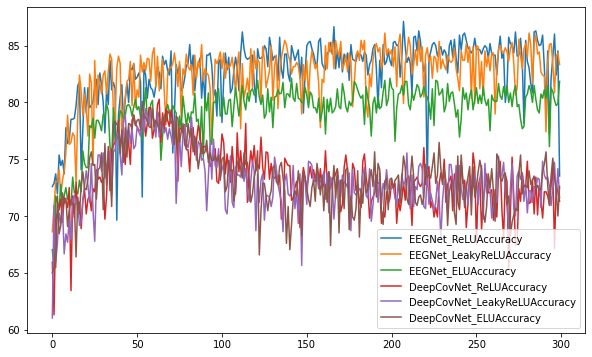

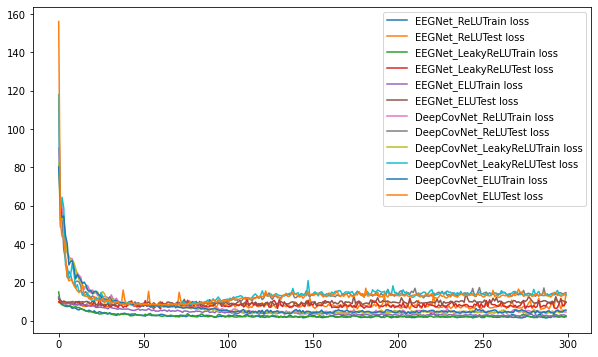

In [10]:
pd_index = ['EEGNet', 'DeepCovNet']
activation_list = ['ReLU', 'LeakyReLU', 'ELU']
tabel_acc = pd.DataFrame(columns=[activation_list], index=pd_index)

table_history = pd.DataFrame()
table_history['epoch'] = range(0, EPOCH)

loss_history = pd.DataFrame()
loss_history['epoch'] = range(0, EPOCH)

for row, model_name in enumerate(pd_index):
    history_acc = []
    for activation_function in activation_list:
        # activation
        if activation_function == 'ReLU' :
            activation = nn.ReLU() 
        if activation_function == 'LeakyReLU' :
            activation = nn.LeakyReLU()
        if activation_function == 'ELU' : 
            activation = nn.ELU()

        # compile model 
        model = EEGNet(activation=activation) if model_name == 'EEGNet' else  DeepConvNet(activation=activation)
        model.to(device)
        

        # loss & optimizer
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
        criterion = nn.CrossEntropyLoss()

        # train
        best_acc_test = 0.0
        epoch_acc = list()
        train_loss_history = list()
        test_loss_history = list()
        for epoch in range(EPOCH):
            train_loss = 0.0
            test_loss = 0.0
            model.train()
            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                #inputs, labels = data
                inputs, labels = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.long)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                train_loss += loss.item()
            
            model.eval()
            # prepare to count predictions for each class
            correct = 0
            total = 0
            with torch.no_grad():
                for i, data in enumerate(test_loader):
                    inputs, labels = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.long)
                    outputs = model(inputs)
                    loss2 = criterion(outputs, labels)
                    _, predictions = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predictions == labels).sum().item()
                    test_loss += loss2.item()
            acc = float(100 * correct / total)
            
            if acc > best_acc_test:
                best_acc_test = acc

            train_loss_history.append(train_loss)
            test_loss_history.append(test_loss)
            epoch_acc.append(acc)
            #print(f'Epoch : {epoch} Train Loss : {train_loss:.2f} Test Loss : {test_loss:.2f} Accuracy : {acc:.2f} % Best accuracy : {best_acc_test:.2f} % ')
        history_acc.append(best_acc_test)
        table_history[model_name + '_' + activation_function + 'Accuracy'] = epoch_acc
        loss_history[model_name + '_' + activation_function + 'Train loss'] = train_loss_history
        loss_history[model_name + '_' + activation_function + 'Test loss'] = test_loss_history
    tabel_acc.iloc[row] = history_acc
        
print(tabel_acc)
figure=plot(table_history)
figure.savefig('Result.png')
figure2 = plot(loss_history)
figure2.savefig('loss.png')